$$\textbf{PREDICTING RECESSION IN AFRICA}$$

*__Use case__: Using economic variables to predict recession of an African country*

### Outline

1. Loading of libraries 
    - *What libraries are necessary for preprocessing, data visualization, machine learning and deep learning?*

2. Loading of dataset  
    - *What dataframe of the data was loaded?*

3. Data exploration 
    - *Which data visualizations were used to check inconsistencies in data?*

4. Feature engineering 
    - *If inconsistencies exist in the data set, which preprocessing methods were necessary?*

5. Modelling (Machine learning and deeplearning algorithms) 
    - *Which machine learning and deep learnining models are good at classifying African countries as being in recession or not?*

6. Saving and loading best model 
    - *Which model can be deployed?*



# Loading of libraries

In [ ]:
#Installing pyspark 
!pip install pyspark==2.4.5

In [ ]:
#Installing tensorflow
!pip install tensorflow==2.2.0rc0

In [8]:
#Libraries for spark sql API
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, explode, array, lit
from pyspark.sql.functions import isnan, when, count, col

In [9]:
#Setting up spark session
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
sqlContext = SQLContext(sc)
spark = SparkSession \
    .builder \
    .getOrCreate()

In [10]:
#Libraries for spark machine learning API
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml import PipelineModel

In [11]:
#Libraries for deep learning
#from tensorflow.keras import Sequential
import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
from tensorflow.keras import optimizers

In [12]:
#sklearn libraries
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [1]:
#Libraries for manipulating data structure
import numpy as np
import pandas as pd

In [14]:
#Plotting library
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


# Loading dataset 

The data was obtained from https://www.kaggle.com/chirin/african-country-recession-dataset-2000-to-2017

The dataset has 49 feature variables and 1 target variable (i.e. the ‘growthbucket’ variable). There is a total of 486 samples in the dataset. 92.81% of the samples belong to the “0”, or “No_Recession” class. And, 7.82% of the samples belong to the “1” or “Recession” class. In short, the dataset has a class imbalance. It is useful for learning techniques for dealing with class imbalance like Cost-Sensitive Classification, Oversampling and Undersampling. For descriptions of the variables, see the attached file named: VariableDefinitions.csv

Years Covered: 2000 to 2017.

Countries Covered: 27 African Countries Including: Morocco, South Africa, Tanzania, Rwanda, Eswatini, Togo, Burkina Faso, Angola, Tunisia, Nigeria, Kenya, Burundi, Benin, Namibia, Central African Republic, Sudan, Gabon, Niger, Sierra Leone, Lesotho, Mauritania, Senegal, Mauritius, Botswana, Cameroon, Zimbabwe and Mozambique.

In [15]:
#Reading in the data as pyspark dataframe
df=sqlContext.read.format("com.databricks.spark.csv").options(header=True, inferschema='true').load('africa_recession.csv')
df.show(2)

+-----------+-----------+----------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+-----------+-----------+----------+-----------+-----------+-----------+-----------+------+-----------+------+---------------+--------+-----------+------+------------+------------------+-------------+----------------------+---------------+------------------+-----------+------------+
|        pop|        emp|emp_to_pop_ratio|         hc|       ccon|        cda|         cn|         ck|       ctfp|      cwtfp|     rconna|      rdana|       rnna|       rkna|     rtfpna|    rwtfpna|      labsh|        irr|      delta|         xr|     pl_con|      pl_da|    pl_gdpo|      csh_c|      csh_i|      csh_g|      csh_x|       csh_m|      csh_r|       pl_c|      p

In [13]:
print("{} samples".format(df.count()))

486 samples


In [8]:
print("{} Indicators of recession : ".format(len(df.columns[0:-1])), df.columns[0:-1])

49 Indicators of recession :  ['pop', 'emp', 'emp_to_pop_ratio', 'hc', 'ccon', 'cda', 'cn', 'ck', 'ctfp', 'cwtfp', 'rconna', 'rdana', 'rnna', 'rkna', 'rtfpna', 'rwtfpna', 'labsh', 'irr', 'delta', 'xr', 'pl_con', 'pl_da', 'pl_gdpo', 'csh_c', 'csh_i', 'csh_g', 'csh_x', 'csh_m', 'csh_r', 'pl_c', 'pl_i', 'pl_g', 'pl_x', 'pl_m', 'pl_n', 'total', 'excl_energy', 'energy', 'metals_minerals', 'forestry', 'agriculture', 'fish', 'total_change', 'excl_energy_change', 'energy_change', 'metals_minerals_change', 'forestry_change', 'agriculture_change', 'fish_change']


# Data exploration

The following outputs where used to check the scales of each variable

In [19]:
df.describe(df.columns[0:5]).show()

+-------+------------------+-----------------+-------------------+-------------------+------------------+
|summary|               pop|              emp|   emp_to_pop_ratio|                 hc|              ccon|
+-------+------------------+-----------------+-------------------+-------------------+------------------+
|  count|               486|              486|                486|                486|               486|
|   mean|20.185754885652248|7.121089245207817| 0.3578652745617284| 1.7773887860905349| 64361.00694201231|
| stddev|30.037490202762267|9.921471471074096|0.08054086639686492|0.44633861429825583|129634.85679349456|
|    min|       1.061468005|      0.243000001|        0.198212003|        1.069451332|       2781.259277|
|    max|       190.8863068|      65.15654755|        0.555432802|        2.885299683|       758455.1875|
+-------+------------------+-----------------+-------------------+-------------------+------------------+



In [17]:
df.describe(df.columns[5:10]).show()

+-------+------------------+------------------+--------------------+-------------------+------------------+
|summary|               cda|                cn|                  ck|               ctfp|             cwtfp|
+-------+------------------+------------------+--------------------+-------------------+------------------+
|  count|               486|               486|                 486|                486|               486|
|   mean| 80885.98872198758|244224.40158693204|0.004582722318930041|0.45441859672222246|0.4534312095493823|
| stddev|156740.41662413004| 472516.2979172557|0.008209903016915406|0.20656236586299276|0.2030563150206612|
|    min|       2984.366943|       5790.396973|          1.23774E-4|        0.098621696|       0.107789844|
|    max|       896604.8125|        2886311.75|         0.041834991|        0.998187423|       1.031707048|
+-------+------------------+------------------+--------------------+-------------------+------------------+



In [21]:
df.describe(df.columns[10:15]).show()

+-------+------------------+-----------------+------------------+-------------------+-------------------+
|summary|            rconna|            rdana|              rnna|               rkna|             rtfpna|
+-------+------------------+-----------------+------------------+-------------------+-------------------+
|  count|               486|              486|               486|                486|                486|
|   mean| 68169.77934318932|86894.64883008639| 296093.2786490888| 0.9220192882551435| 0.9888842253045266|
| stddev|136352.26885326326|164892.3023420776|512625.14477239724|0.34027744883601946|0.14348247614132065|
|    min|       2786.592285|      2978.288574|       8735.905273|        0.136823729|        0.429514736|
|    max|       762126.9375|      908560.6875|        2592378.25|        3.033908606|        1.956829548|
+-------+------------------+-----------------+------------------+-------------------+-------------------+



In [22]:
df.describe(df.columns[15:20]).show()

+-------+-------------------+-------------------+-------------------+--------------------+------------------+
|summary|            rwtfpna|              labsh|                irr|               delta|                xr|
+-------+-------------------+-------------------+-------------------+--------------------+------------------+
|  count|                486|                486|                486|                 486|               486|
|   mean| 0.9561870828662553| 0.5131589145349796|0.11596246746090536| 0.04808690821604938|447.06946015922625|
| stddev|0.14085954440264598|0.14892250695617115| 0.0736901672550211|0.012163260326569792| 797.2593271840798|
|    min|        0.382910192|         0.16431579|               0.01|         0.024867065|               1.0|
|    max|        1.447287679|        0.837298691|        0.430071384|          0.09394379|       7384.432129|
+-------+-------------------+-------------------+-------------------+--------------------+------------------+



In [23]:
df.describe(df.columns[20:25]).show()

+-------+-------------------+-------------------+-------------------+------------------+-------------------+
|summary|             pl_con|              pl_da|            pl_gdpo|             csh_c|              csh_i|
+-------+-------------------+-------------------+-------------------+------------------+-------------------+
|  count|                486|                486|                486|               486|                486|
|   mean| 0.4205104221810698| 0.4250046772098768|0.41156152709259247|0.6793537782469138|0.20676868048353902|
| stddev|0.12624465354157688|0.11707167291848977|0.11726634518664612|0.1589025524578558|0.08899342345782149|
|    min|        0.150231093|        0.146762177|        0.128689289|       0.223663121|        0.049953714|
|    max|        0.928638339|        0.866255581|        0.809904158|        0.99950105|         0.55602622|
+-------+-------------------+-------------------+-------------------+------------------+-------------------+



In [24]:
df.describe(df.columns[25:30]).show()

+-------+-------------------+-------------------+--------------------+--------------------+-------------------+
|summary|              csh_g|              csh_x|               csh_m|               csh_r|               pl_c|
+-------+-------------------+-------------------+--------------------+--------------------+-------------------+
|  count|                486|                486|                 486|                 486|                486|
|   mean|0.17406058339094643|0.16854312304115232|-0.22567706920987654|-0.00304909612328...| 0.4307191799444443|
| stddev|0.06308155535494409|0.14238558757936626| 0.13254550020918146| 0.09013044379846463|0.13607592446093325|
|    min|        0.016554305|        0.012206023|        -0.784459949|        -0.652756393|        0.154627383|
|    max|        0.406014323|        0.843245864|        -0.017928151|         0.634477556|        0.983001471|
+-------+-------------------+-------------------+--------------------+--------------------+-------------

In [25]:
df.describe(df.columns[30:35]).show()

+-------+-------------------+-------------------+-------------------+-------------------+------------------+
|summary|               pl_i|               pl_g|               pl_x|               pl_m|              pl_n|
+-------+-------------------+-------------------+-------------------+-------------------+------------------+
|  count|                486|                486|                486|                486|               486|
|   mean|0.47453458612139937| 0.4070576722983542| 0.6230575815288063| 0.5925599934115229|0.3944885685781893|
| stddev|0.14265934853514117|0.16030848943291412|0.10442528183751369|0.07635783264172206|0.3868741541022512|
|    min|        0.030469509|        0.044227377|        0.375171423|        0.432635695|       0.062743843|
|    max|        1.183658481|        1.205252767|        1.143189669|        1.077167511|        6.04815197|
+-------+-------------------+-------------------+-------------------+-------------------+------------------+



In [26]:
df.describe(df.columns[35:40]).show()

+-------+-----------------+------------------+------------------+------------------+-----------------+
|summary|            total|       excl_energy|            energy|   metals_minerals|         forestry|
+-------+-----------------+------------------+------------------+------------------+-----------------+
|  count|              486|               486|               486|               486|              486|
|   mean|480.4333333333329|315.39166666666665| 1205.329999999995|  512.912222222222|322.4116666666655|
| stddev|132.3236815329477| 65.32237959993458|416.62893979838447|173.04087617205295|44.31522162799297|
|    min|           274.69|            205.27|            586.13|             241.9|           245.56|
|    max|           689.92|            415.18|           1985.48|            775.13|           417.58|
+-------+-----------------+------------------+------------------+------------------+-----------------+



In [27]:
df.describe(df.columns[40:45]).show()

+-------+-----------------+------------------+--------------------+--------------------+-------------------+
|summary|      agriculture|              fish|        total_change|  excl_energy_change|      energy_change|
+-------+-----------------+------------------+--------------------+--------------------+-------------------+
|  count|              486|               486|                 486|                 486|                486|
|   mean|221.3266666666671|1009.4455555555575|0.044535174388889036|0.030345598888888586|0.08241084088888918|
| stddev|49.80398099850023|140.12595066839575| 0.18402456901078063| 0.10561553527553064| 0.2884542943408308|
|    min|           149.37|            843.66|        -0.359446025|        -0.173740819|       -0.477016807|
|    max|           308.05|           1276.53|         0.264843177|         0.218346485|        0.717188407|
+-------+-----------------+------------------+--------------------+--------------------+-------------------+



In [29]:
df.describe(df.columns[45:49]).show()

+-------+----------------------+--------------------+-------------------+--------------------+
|summary|metals_minerals_change|     forestry_change| agriculture_change|         fish_change|
+-------+----------------------+--------------------+-------------------+--------------------+
|  count|                   486|                 486|                486|                 486|
|   mean|   0.05814413955555613|0.024774265611111106|0.03392966194444454|0.023741117222222264|
| stddev|   0.15128549068573974| 0.12992404172216235| 0.1271012988485256|  0.0769372588231712|
|    min|          -0.157563882|        -0.174550411|       -0.225998493|         -0.11385837|
|    max|           0.476204364|         0.300217461|        0.320880178|         0.165440237|
+-------+----------------------+--------------------+-------------------+--------------------+



The following was used to check if there are missing values

In [9]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---+---+----------------+---+----+---+---+---+----+-----+------+-----+----+----+------+-------+-----+---+-----+---+------+-----+-------+-----+-----+-----+-----+-----+-----+----+----+----+----+----+----+-----+-----------+------+---------------+--------+-----------+----+------------+------------------+-------------+----------------------+---------------+------------------+-----------+------------+
|pop|emp|emp_to_pop_ratio| hc|ccon|cda| cn| ck|ctfp|cwtfp|rconna|rdana|rnna|rkna|rtfpna|rwtfpna|labsh|irr|delta| xr|pl_con|pl_da|pl_gdpo|csh_c|csh_i|csh_g|csh_x|csh_m|csh_r|pl_c|pl_i|pl_g|pl_x|pl_m|pl_n|total|excl_energy|energy|metals_minerals|forestry|agriculture|fish|total_change|excl_energy_change|energy_change|metals_minerals_change|forestry_change|agriculture_change|fish_change|growthbucket|
+---+---+----------------+---+----+---+---+---+----+-----+------+-----+----+----+------+-------+-----+---+-----+---+------+-----+-------+-----+-----+-----+-----+-----+-----+----+----+----+----+----+--

In [16]:
#Converting pyspark dataframe to pandas dataframe
df_pd=df.toPandas()

The following boxplots were used to check for presence of outliers in each variable

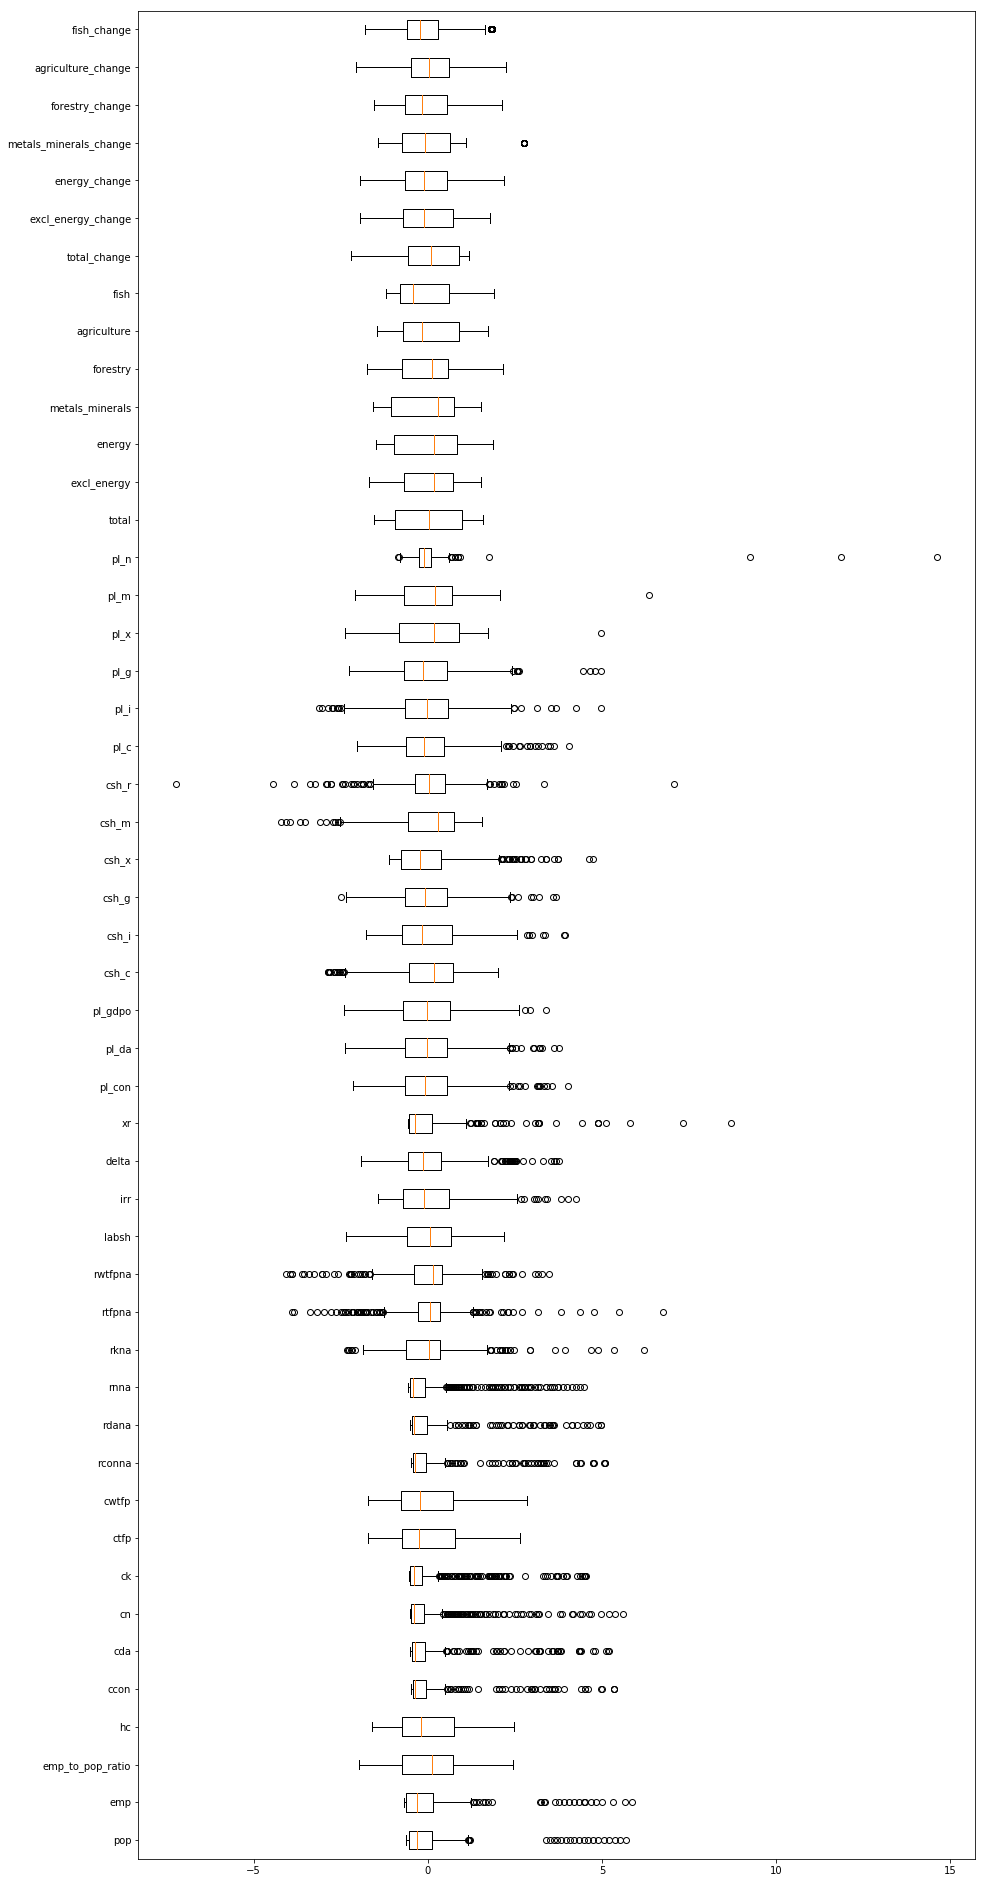

In [97]:
#Box plot creation
data_bp = df_pd.drop(['growthbucket'], axis=1)
data_scaled = scale(data_bp)

# Create a figure instance
fig = plt.figure(1, figsize=(15, 34))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bxlabs=list(data_bp)

# Create the boxplot
bp = ax.boxplot(data_scaled,labels=bxlabs,showfliers=True,vert=False)
plt.show()

The following visualisation was used to check if there exist multicollinearity among the features

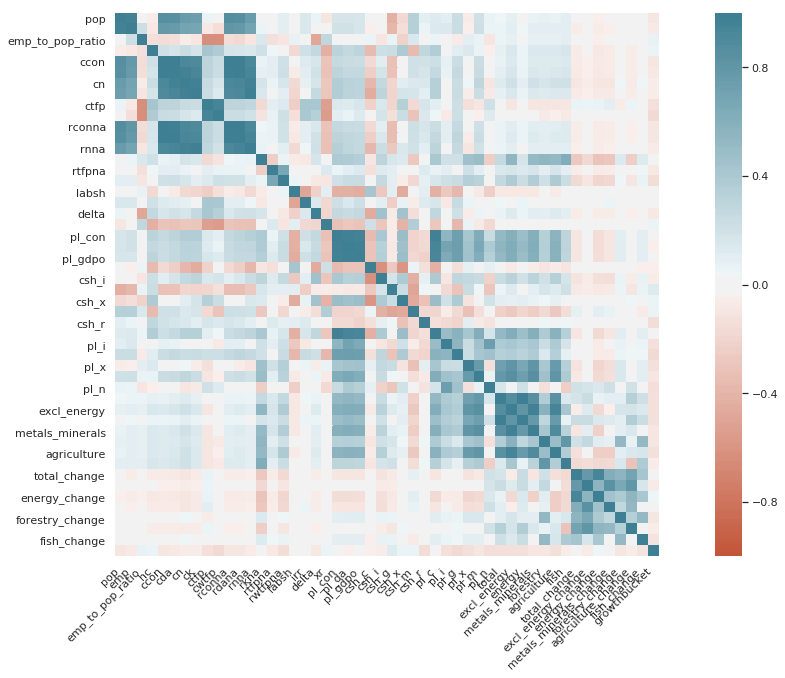

In [39]:
pd_corr=df_pd.corr()
ax = sn.heatmap(
    pd_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sn.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
sn.set(rc={'figure.figsize':(20,10)}
      );

In [13]:
#Extracting the target, growthbucket 
df.createOrReplaceTempView("Recession")
count_df=spark.sql("SELECT growthbucket FROM Recession")
bucket_rdd=count_df.rdd.map(lambda row : (row.growthbucket))

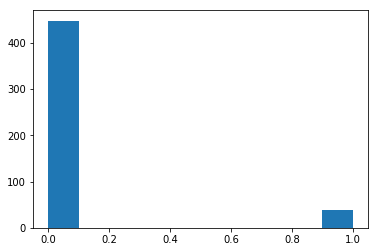

In [8]:
plt.hist(bucket_rdd.collect())
plt.show()

Things observed so far: 

1) The features are not of the same scale 

2) There are no missing observations observations in any of the features 

3) There are outliers in some features in the data 

4) There is some level of multicollinearity among features

5) There is class imbalance in the target

# Featuring engineering

### 1) Handling of outliers

In [17]:
#Function to impute the outliers with upper or lower limits a distribution
def winsorize(Ys):
    
    Q1 = Ys.quantile(0.25)  #First quartile 
    Q3 = Ys.quantile(0.75)  #Third quartile
    IQR = Q3 - Q1           #Interquartile range
    upper_bound =  Q3 + (1.5 * IQR)    #Upper limit
    lower_bound = Q1 - (1.5 * IQR)       #Lower limit
    
    #Imputing the outliers with upper and lower limit
    value_outlier_Y_up = Ys > upper_bound  
    value_outlier_Y_low = Ys < lower_bound
    outlier_listUB=len(Ys[value_outlier_Y_up])
    outlier_listLB=len(Ys[value_outlier_Y_low])
    if outlier_listUB != 0:
        Ys = Ys.replace(Ys[value_outlier_Y_up], upper_bound)
    if outlier_listLB != 0:
        Ys = Ys.replace(Ys[value_outlier_Y_low], lower_bound) 
    
    return Ys

In [18]:
#Applying truncate function to the data
features= df.columns[0:-1]
for feature in features:
    df_pd[feature]=winsorize(df_pd[feature])

In [13]:
#Check to see if outliers are present in the features after applying truncate function
for feature in features:
    Q1 = df_pd[feature].quantile(0.25)  #First quartile 
    Q3 = df_pd[feature].quantile(0.75)  #Third quartile
    IQR = Q3 - Q1           #Interquartile range
    upper_bound =  Q3 + (1.5 * IQR)    #Upper limit
    lower_bound = Q1 - (1.5 * IQR)       #Lower limit
    
    #Imputing the outliers with upper and lower limit
    value_outlier_Y_up = df_pd[feature] > upper_bound  
    value_outlier_Y_low = df_pd[feature] < lower_bound
    numb_outliers=len(df_pd.loc[value_outlier_Y_up,feature]) + len(df_pd.loc[value_outlier_Y_low,feature])
    print("**************************************")
    print("{} has {} outliers".format(feature,numb_outliers))

**************************************
pop has 0 outliers
**************************************
emp has 0 outliers
**************************************
emp_to_pop_ratio has 0 outliers
**************************************
hc has 0 outliers
**************************************
ccon has 0 outliers
**************************************
cda has 0 outliers
**************************************
cn has 0 outliers
**************************************
ck has 0 outliers
**************************************
ctfp has 0 outliers
**************************************
cwtfp has 0 outliers
**************************************
rconna has 0 outliers
**************************************
rdana has 0 outliers
**************************************
rnna has 0 outliers
**************************************
rkna has 0 outliers
**************************************
rtfpna has 0 outliers
**************************************
rwtfpna has 0 outliers
**************************************
labsh

### 2) Normalizing the features

Normalisation will prevent extreme influence on the target from features based on their large scales.

In [19]:
norm_np=preprocessing.normalize(df_pd.loc[:,features], norm='l2')

In [20]:
norm_pd=pd.DataFrame(data=norm_np,columns=features)
norm_pd['growthbucket']=df_pd['growthbucket']
df_spark=spark.createDataFrame(norm_pd)

### 3) Handling class imbalance

In [21]:
major_df = df_spark.filter(col("growthbucket") == 0) #Filtering data based on "No recession" class
minor_df = df_spark.filter(col("growthbucket") == 1) #Filtering data based on "Recession" class
ratio = int(major_df.count()/minor_df.count())

a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
df_spark_new = major_df.unionAll(oversampled_df)

In [16]:
#Checking distribution of growthbucket variable
df_spark_new.createOrReplaceTempView("Rec_new")
spark.sql("select growthbucket, count(*) as distribution from Rec_new group by growthbucket").show()

+------------+------------+
|growthbucket|distribution|
+------------+------------+
|           0|         448|
|           1|         418|
+------------+------------+



To re-use the processed data in the future without having to re-run the codes for feature engineering again, I decided to save it as csv

In [22]:
df_spark_new.write.csv('africa_recession_new.csv')

# Modelling

## I. Modelling with traditional machine learning algorithm

In [23]:
#Splitting data into training and testing data
(trainingData, testData) = df_spark_new.randomSplit([0.8, 0.2])

In [41]:
print(trainingData.columns)

['pop', 'emp', 'emp_to_pop_ratio', 'hc', 'ccon', 'cda', 'cn', 'ck', 'ctfp', 'cwtfp', 'rconna', 'rdana', 'rnna', 'rkna', 'rtfpna', 'rwtfpna', 'labsh', 'irr', 'delta', 'xr', 'pl_con', 'pl_da', 'pl_gdpo', 'csh_c', 'csh_i', 'csh_g', 'csh_x', 'csh_m', 'csh_r', 'pl_c', 'pl_i', 'pl_g', 'pl_x', 'pl_m', 'pl_n', 'total', 'excl_energy', 'energy', 'metals_minerals', 'forestry', 'agriculture', 'fish', 'total_change', 'excl_energy_change', 'energy_change', 'metals_minerals_change', 'forestry_change', 'agriculture_change', 'fish_change', 'growthbucket']


### 1) Building model with 5-fold cross validation

In [24]:
vectorAssembler =  VectorAssembler(inputCols=features, outputCol="features") #Initializing vector assembler constructor
classifier = RandomForestClassifier(featuresCol='features', labelCol='growthbucket') #Initializing random forest classifier constructor
evaluator = BinaryClassificationEvaluator(labelCol='growthbucket')
#grid = ParamGridBuilder().addGrid(classifier.maxIter, [0, 1]).build()import numpy as np

paramGrid = ParamGridBuilder() \
    .addGrid(classifier.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(classifier.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

In [25]:
pipeline = Pipeline(stages=[vectorAssembler, classifier]) #Initializing the pipeline constructor with vector assembler and classifier

In [26]:
#Initialising the cross validator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

In [27]:
#Fitting model on training data
best_model = crossval.fit(trainingData)

In [51]:
#Evaluating model on test data
predictions=best_model.transform(testData)
print("Accuracy : ",evaluator.evaluate(predictions)*100)

Accuracy :  100.0


In [21]:
#Function to summarise the recall, precision and F1-score of a model
def metrics(target,prediction):
    print("**********************")
    print("Recall : ",recall_score(target, prediction, average='binary')*100)
    print("**********************")
    print("Precission : ", precision_score(target, prediction, average='binary')*100 )
    print("**********************")
    print("F1 score : ", f1_score(target, prediction, average='binary')*100 )

In [50]:
target_cv=testData.rdd.map(lambda row : (row.growthbucket)).collect()
prediction_cv=predictions.rdd.map(lambda row : (row.prediction)).collect()
metrics(target_cv,prediction_cv)

**********************
Recall :  100.0
**********************
Precission :  100.0
**********************
F1 score :  100.0


In [60]:
#Distribution of the predicted classes
spark.sql("select prediction, count(*) as distribution from prediction group by prediction").show()

+----------+------------+
|prediction|distribution|
+----------+------------+
|       0.0|          87|
|       1.0|          84|
+----------+------------+



### 2) Building model with Validation set approach

In [21]:
#Fitting model to training data
vs_model = pipeline.fit(trainingData)

In [52]:
#Evaluating model on test data
predictions2=vs_model.transform(testData)
print("Accuracy : ",evaluator.evaluate(predictions2)*100)

Accuracy :  99.624765478424


In [47]:
target_vs=testData.rdd.map(lambda row : (row.growthbucket)).collect()
prediction_vs=predictions2.rdd.map(lambda row : (row.prediction)).collect()

In [48]:
metrics(target_vs,prediction_vs)

**********************
Recall :  100.0
**********************
Precission :  93.18181818181817
**********************
F1 score :  96.47058823529412


In conclusion, the random forest classifier trained with the 5-fold cross validation is better than that trained with validation set approach. This was based on the comparison of their respective accuracies and F1 score. 

Next we want know how much each recession indicator is contributing to prediction of recession 

# II. Modelling with deep learning algorithm

### 1) Training network with validation set approach

In [22]:
train_X=np.array(trainingData.select(features).collect())
train_y=np.array(trainingData.select("growthbucket").collect())
test_X=np.array(testData.select(features).collect())
test_y=np.array(testData.select("growthbucket").collect())

In [23]:
number_of_neurons_layer1 = 12 #input layer
number_of_neurons_layer2 = 8 #hidden layer
number_of_neurons_layer3 =1 #output layer
number_of_epochs = 150 #Number of epochs

In [24]:
optimizers = ['Adam','Adadelta','Adagrad','Adamax']
for opt in optimizers:
    model = Sequential()
    model.add(Dense(number_of_neurons_layer1,input_shape=(train_X.shape[1], ), activation='relu'))
    model.add(Dense(number_of_neurons_layer2, activation='relu'))
    model.add(Dense(number_of_neurons_layer3, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy'])
    model.fit(train_X,train_y ,epochs=number_of_epochs, batch_size=10, verbose=0, shuffle=True)
    deep_pred=model.predict_classes(test_X)
    print("Accuracy trained with {} ".format(opt),accuracy_score(test_y, deep_pred)*100 )

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy trained with Adam  80.54054054054053
Accuracy trained with Adadelta  44.32432432432433
Accuracy trained with Adagrad  56.75675675675676
Accuracy trained with Adamax  71.35135135135135


In [25]:
model = Sequential()
model.add(Dense(number_of_neurons_layer1,input_shape=(train_X.shape[1], ), activation='relu'))
model.add(Dense(number_of_neurons_layer2, activation='relu'))
model.add(Dense(number_of_neurons_layer3, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer="Adam",metrics=['accuracy'])
model.fit(train_X,train_y ,epochs=number_of_epochs, batch_size=10, verbose=0, shuffle=True)

In [27]:
metrics(test_y,model.predict_classes(test_X))

**********************
Recall :  90.72164948453609
**********************
Precission :  77.87610619469027
**********************
F1 score :  83.80952380952381


# Save and loading best model

So far, the traditional machine learning model was confirmed to be quite good on generalising on unseen data based on accuracy and F1 scores. Therefore, this model could be potential candidate for predicting future recession for the 27 mentioned African countries.

In [28]:
#Saving model
best_model.bestModel.write().overwrite().save("Best_model")

In [33]:
#Loading in the saved model into program
best_model=PipelineModel.load("Best_model")

In [34]:
loaded_preds=best_model.transform(testData)
evaluator.evaluate(loaded_preds)*100

100.0

To make predictions of recession, it would be necessary to find out which indicators or predictors of recession were the most influential. This will be necessary for stakeholders responsible for enforcing policies that help bring out a country from a recession or prevent getting into a recession

In [62]:
# This function create a dataframe of features and their respective importance
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [66]:
# Extracting importances from the model
feat_imp=best_model.stages[-1].featureImportances

# Applying the 'ExtractFeatureImp()'
imp_df=ExtractFeatureImp(feat_imp, predictions, "features").loc[:,["name","score"]]
imp_df.sort_values(by="score", axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

,name,score
10,rconna,0.094744
4,ccon,0.051333
11,rdana,0.037552
19,xr,0.033638
7,ck,0.032666
14,rtfpna,0.032371
18,delta,0.031196
6,cn,0.030347
29,pl_c,0.029530
15,rwtfpna,0.029114


After the features were normalised during the feature engineering step, it rendered the features to have comparable influence on the target variabe (growthbucket). However, it can be clearly be seen that there are features with higher influnce than others

In [70]:
#Summarising the features with importances above average
mean_score=imp_df["score"].mean()
print("Features with importance above average : ",list(imp_df.loc[imp_df["score"]>mean_score,"name"]))

Features with importance above average :  ['rconna', 'ccon', 'rdana', 'xr', 'ck', 'rtfpna', 'delta', 'cn', 'pl_c', 'rwtfpna', 'csh_m', 'excl_energy_change', 'rnna', 'pl_gdpo', 'pl_x', 'csh_x', 'energy_change', 'forestry_change', 'cwtfp']


In [5]:
len(['rconna', 'ccon', 'rdana', 'xr', 'ck', 'rtfpna', 'delta', 'cn', 'pl_c', 'rwtfpna', 'csh_m', 'excl_energy_change', 'rnna', 'pl_gdpo', 'pl_x', 'csh_x', 'energy_change', 'forestry_change', 'cwtfp'])

19

In [2]:
from textblob import TextBlob

In [4]:
TextBlob

TypeError: __init__() missing 1 required positional argument: 'text'